Primero bandits luego steps

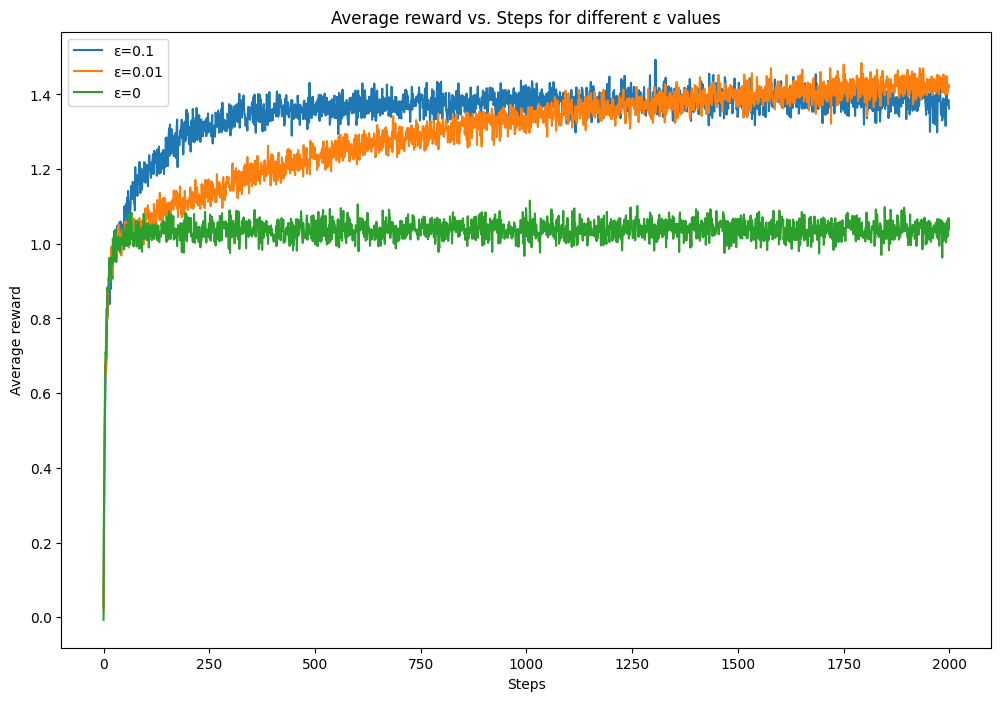

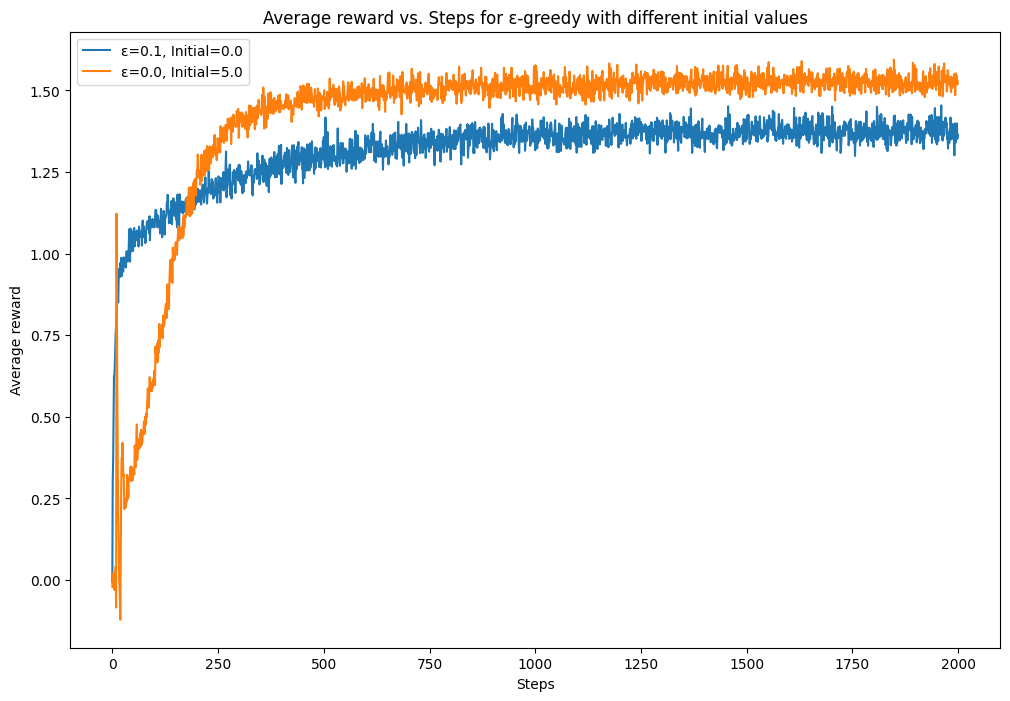

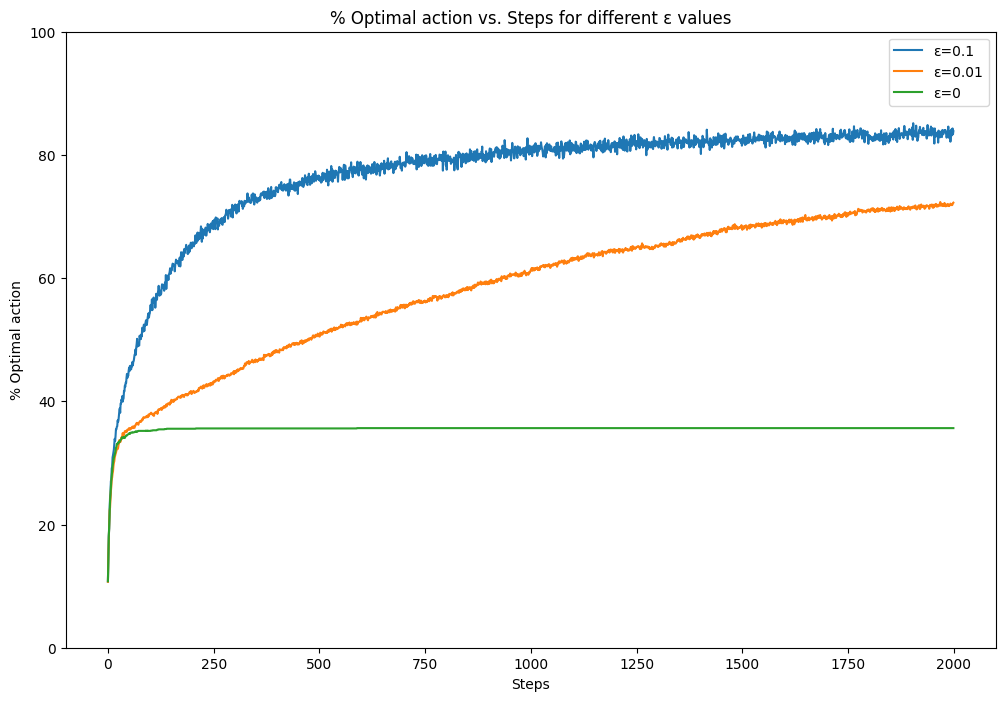

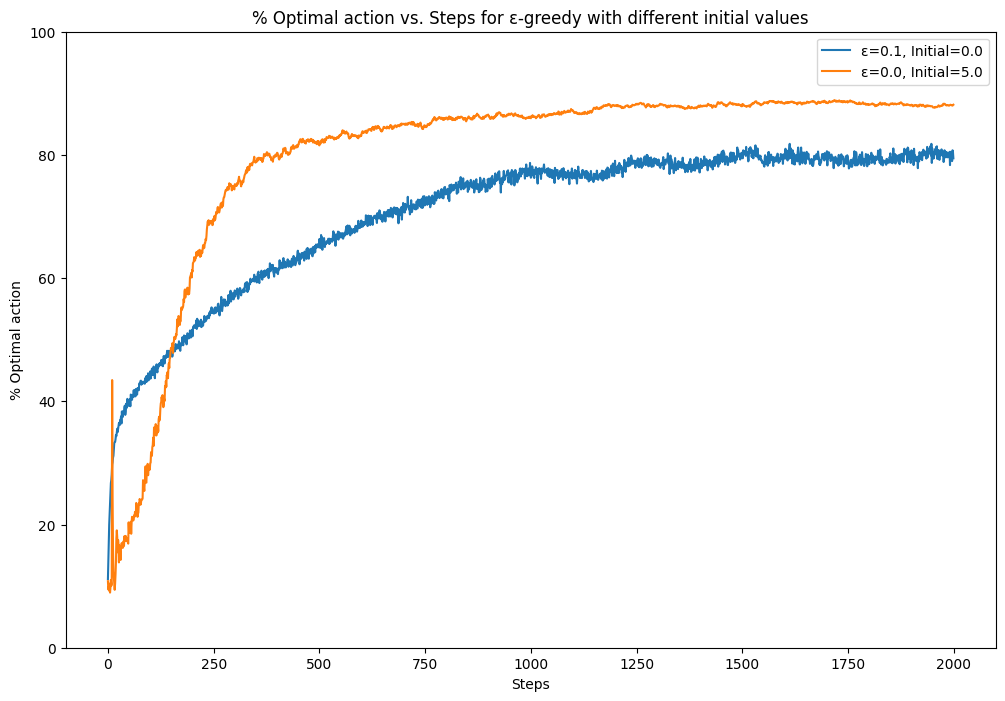

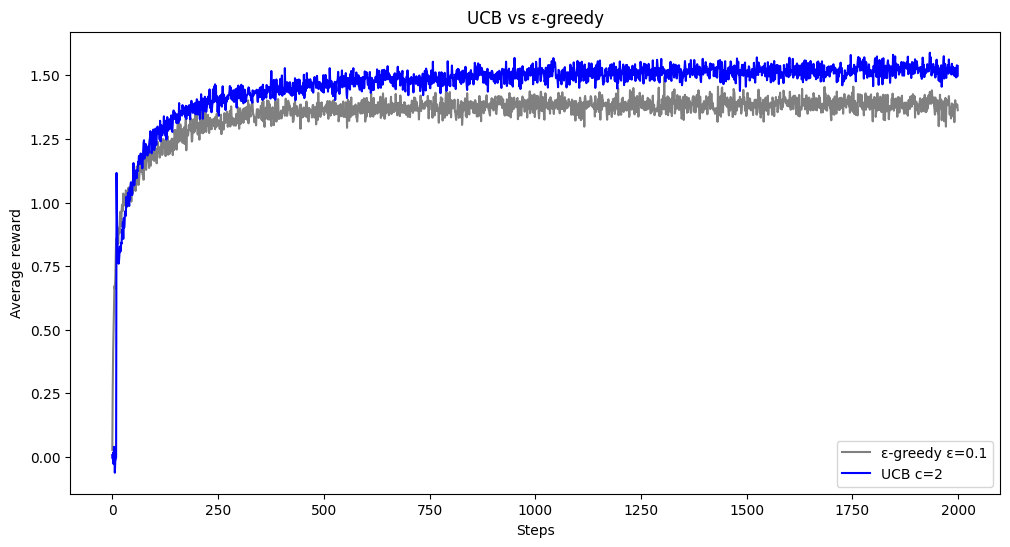

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class MultiArmedBandit:
    def __init__(self, k=10):
        self.k = k
        self.q_star = np.random.normal(0, 1, k)

    def get_reward(self, action):
        # Distribución para cada brazo del bandit
        return np.random.normal(self.q_star[action], 1)

class EpsilonGreedyAgent:
    def __init__(self, k=10, epsilon=0.1, initial=0.0, step_size=0.1, use_sample_average=False):
        self.k = k
        self.epsilon = epsilon
        # inicializa el array self.Q con k elementos, cada uno de los cuales se establece en el valor "initial"
        self.Q = np.full(k, initial)
        self.N = np.zeros(k)
        self.step_size = step_size
        self.use_sample_average = use_sample_average  # Determina el método de actualización

    def select_action(self):
      # Estrategia epsilon-greeedy
      # Genera un número aleatorio entre 0 y 1 y si es menor que epsilon selecciona aleatoriamente un brazo (exploración)
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.k)
      # Selecciona la acción con mejor estimación hasta el momento (explotación)
        else:
            return np.argmax(self.Q)

    def update_Q(self, action, reward):
        self.N[action] += 1
        if self.use_sample_average:
            # Tamaño del step utilizando el promedio de muestras
            step_size = 1.0 / self.N[action]
        else:
            # Tamaño del step utilizando una tasa de aprendizaje constante
            step_size = self.step_size
        # Actualización de Q
        self.Q[action] += step_size * (reward - self.Q[action])

class UCBAgent:
    def __init__(self, k=10, c=2):
        self.k = k
        self.Q = np.zeros(k)
        self.N = np.zeros(k)
        self.c = c

    def select_action(self, t):
        # Se aplica ecuación (2.10) del libro
        # Se introduce 1e-5 << 1 para evitar la división por cero
        # Q se calcula del método update_Q (abajo)
        # Acción preferida:
        confidence_bounds = self.Q + self.c * np.sqrt(np.log(t + 1) / (self.N + 1e-5))
        return np.argmax(confidence_bounds)
    # Actualización de Q
    def update_Q(self, action, reward):
        self.N[action] += 1
        # Recompensa promedio
        self.Q[action] += (reward - self.Q[action]) / self.N[action]


class Simulation:
    def __init__(self, k, num_bandits, steps, epsilon_values, initial_values):
        self.k = k
        self.num_bandits = num_bandits
        self.steps = steps
        self.epsilon_values = epsilon_values
        self.initial_values = initial_values
        # Se crea cada bandit
        self.bandits = [MultiArmedBandit(k) for _ in range(num_bandits)]

    def run(self):
        # Tablas que llevan el registro de los distintos pares epsilon, initial (optimistic value) y recompensas a lo largo de los 2000 pasos
        self.all_average_rewards = np.zeros((len(self.epsilon_values) + len(self.initial_values), self.steps))
        self.all_optimal_actions = np.zeros((len(self.epsilon_values) + len(self.initial_values), self.steps))

        # Simulación para diferentes valores de épsilon
        # Estrategia epsilon-greedy para gráficas 2.2
        for i, epsilon in enumerate(self.epsilon_values):
            use_sample_average = epsilon in [0, 0.01, 0.1]  # Utiliza promedio de muestras para estos valores de épsilon
            for bandit in self.bandits:
                # Utiliza tasa de aprendizaje constante
                agent = EpsilonGreedyAgent(k=self.k, epsilon=epsilon, use_sample_average=use_sample_average) # Utiliza tasa de aprendizaje constante
                for step in range(self.steps):
                    action = agent.select_action()
                    # Recompensa del objeto bandit
                    reward = bandit.get_reward(action)
                    agent.update_Q(action, reward)
                    self.all_average_rewards[i, step] += reward
                    if action == np.argmax(bandit.q_star): # Checa: ¿Es la acción óptima?
                        self.all_optimal_actions[i, step] += 1

        # Simulación para diferentes valores iniciales
        # Para gráfica 2.3
        for j, (epsilon, initial) in enumerate(self.initial_values):
            # Valores optimistas (Q_1 > 0 ) con epsilon
            use_sample_average = not ((initial == 0 and epsilon == 0.1) or (initial == 5 and epsilon == 0))
            index = j + len(self.epsilon_values)
            for bandit in self.bandits:
                agent = EpsilonGreedyAgent(k=self.k, epsilon=epsilon, initial=initial, use_sample_average=use_sample_average)
                for step in range(self.steps):
                    action = agent.select_action()
                    # Recompensa del objeto bandit
                    reward = bandit.get_reward(action)
                    agent.update_Q(action, reward)
                    self.all_average_rewards[index, step] += reward
                    if action == np.argmax(bandit.q_star):
                        self.all_optimal_actions[index, step] += 1

        # Promedio de las recompensas y porcentaje de acciones óptimas tomadas
        self.all_average_rewards /= self.num_bandits
        self.all_optimal_actions = (self.all_optimal_actions / self.num_bandits) * 100

    # Gráfica 2.2 (primera)
    def plot_results(self):
        plt.figure(figsize=(12, 8))
        for i, epsilon in enumerate(self.epsilon_values):
            plt.plot(self.all_average_rewards[i], label=f'ε={epsilon}')
        plt.xlabel('Steps')
        plt.ylabel('Average reward')
        plt.title('Average reward vs. Steps for different ε values')
        plt.legend()
        plt.show()

        plt.figure(figsize=(12, 8))
        for j, (epsilon, initial) in enumerate(self.initial_values):
            index = j + len(self.epsilon_values)
            label = f'ε={epsilon}, Initial={initial}'
            plt.plot(self.all_average_rewards[index], label=label)
        plt.xlabel('Steps')
        plt.ylabel('Average reward')
        plt.title('Average reward vs. Steps for ε-greedy with different initial values')
        plt.legend()
        plt.show()

  # Gráfica 2.2 (segunda)
  # Gráfica 2.3
    def plot_optimal_actions(self):
        plt.figure(figsize=(12, 8))
        for i, epsilon in enumerate(self.epsilon_values):
            plt.plot(self.all_optimal_actions[i], label=f'ε={epsilon}')
        plt.xlabel('Steps')
        plt.ylabel('% Optimal action')
        plt.title('% Optimal action vs. Steps for different ε values')
        plt.legend()
        plt.ylim(0, 100)
        plt.show()

        plt.figure(figsize=(12, 8))
        for j, (epsilon, initial) in enumerate(self.initial_values):
            index = j + len(self.epsilon_values)
            label = f'ε={epsilon}, Initial={initial}'
            plt.plot(self.all_optimal_actions[index], label=label)
        plt.xlabel('Steps')
        plt.ylabel('% Optimal action')
        plt.title('% Optimal action vs. Steps for ε-greedy with different initial values')
        plt.legend()
        plt.ylim(0, 100)
        plt.show()


    # Gráfica 2.4
    # UCB vs ε-greedy
    def plot_ucb_comparison(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.all_average_rewards[0], label='ε-greedy ε=0.1', color='grey')
        # Arreglo donde se guardan las recompensas UCB
        ucb_rewards = np.zeros(self.steps)

        # Agente UCB
        for bandit in self.bandits:
            agent = UCBAgent(k=self.k)
            for step in range(self.steps):
                action = agent.select_action(step)
                # Recompensa del objeto bandit
                reward = bandit.get_reward(action)
                agent.update_Q(action, reward)
                ucb_rewards[step] += reward

        # Promedios de recompensas
        ucb_rewards /= self.num_bandits
        plt.plot(ucb_rewards, label='UCB c=2', color='blue')

        plt.xlabel('Steps')
        plt.ylabel('Average reward')
        plt.title('UCB vs ε-greedy')
        plt.legend()
        plt.show()

# Parámetros de la simulación
k = 10
num_bandits = 2000
steps = 2000
epsilon_values = [0.1, 0.01, 0]  # Valores de epsilon para explorar
initial_values = [(0.1, 0.0), (0.0, 5.0)]  # (epsilon, valor inicial)

# Ejecutar la simulación con los parámetros especificados
simulation = Simulation(k=k, num_bandits=num_bandits, steps=steps, epsilon_values=epsilon_values, initial_values=initial_values)
simulation.run()
simulation.plot_results()
simulation.plot_optimal_actions()
simulation.plot_ucb_comparison()